# "Should I buy a house?"

It's shockingly hard to know how much it costs to buy, and every house is different, and this has vexed me for months.  In learning to answer the question, I needed to learn:

## The subquestions

 * How do mortgages work?
 * What is involved in buying a house?
 * How can investments be compared?
 * How do taxes work?
 * How does renting out rooms change the math?
 
And I've learned a ton!  This workbook is to share that.

### How do mortgages work?

Let's pretend we are looking at a $1,000,000 home, just for very round numbers.  What is the monthly payment on that?

In [1]:
import numpy_financial as npf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# %load_ext lab_black

mortgage_interest = 0.05  # Rate on the mortgage
periods = np.arange(12 * 30)  # 30 year term
home_value = 1100000  # Million dollar house
down_payment_pct = 0.11  # 20% down
down_payment = home_value * down_payment_pct
mortgage_amount = home_value - down_payment

plt.rcParams['font.size'] = '20'

Numpy Financial lets us easily pull out the payments for each month for mortgage and interest. Mortgages are [fully-amortized loans](https://www.investopedia.com/terms/f/fully_amortizing_payment.asp), meaning they are a flat payment every period, but the amount of money going to paying down the principal changes. 

In [2]:
interest_payment = npf.ipmt(mortgage_interest / 12, periods, 12 * 30, mortgage_amount)
principal_payment = npf.ppmt(mortgage_interest / 12, periods, 12 * 30, mortgage_amount)
total_payment = npf.pmt(mortgage_interest / 12, 12 * 30, mortgage_amount)

In [3]:
# The total monthly payment is the sum of the interest and the principal
np.testing.assert_allclose(
    interest_payment + principal_payment, total_payment, rtol=1e-9
)

We can throw this data into a container and plot it for visibility

In [4]:
df = pd.DataFrame(
    data={
        "month": np.arange(360),
        "interest": interest_payment,
        "principal": principal_payment,
    }
)

/tmp/ipykernel_119497/3307871255.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])


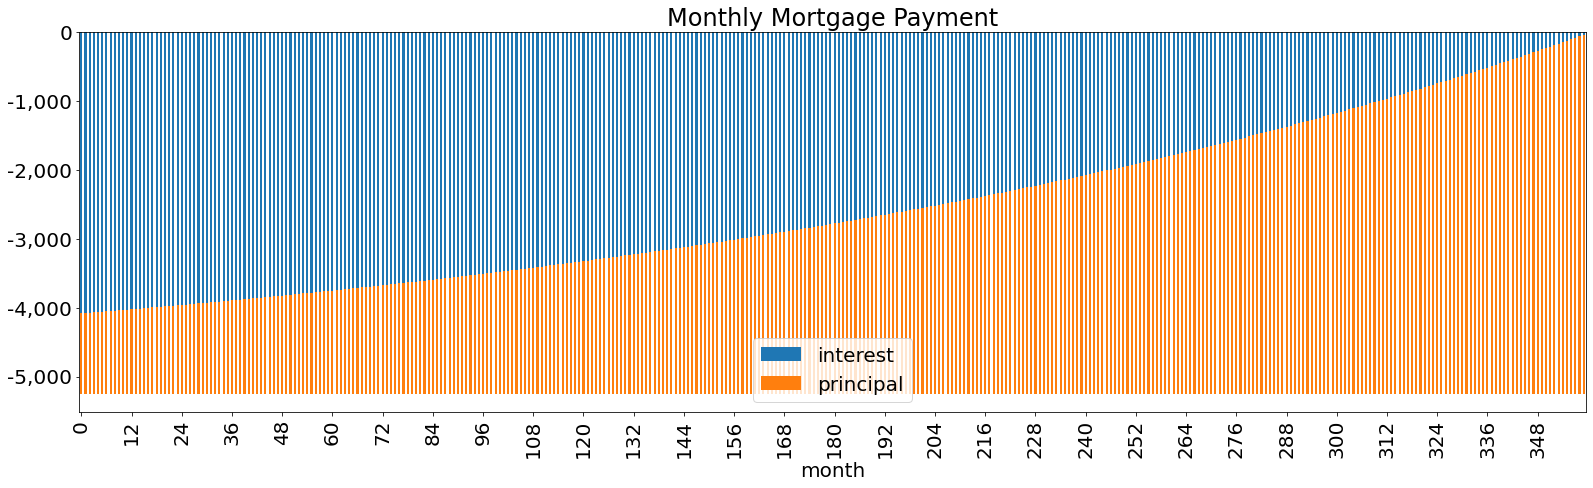

In [5]:
def plot_payments(df, title="Monthly Mortgage Payment"):
    ax = df.plot(x="month", kind="bar", stacked=True, figsize=(27, 7), title=title)
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
    ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])
    plt.show()


plot_payments(df)

This picture makes very clear how interest payments change over time.  In the early months of a mortgage, you are _mostly_ paying interest, ie **not really making progress on your mortgage**.

### Home Values Change

Home values generally appreciate, though slowly.  Since 1891, home values have gone up 3.2% annually in nominal money, ie including inflation.  From here on, I will handle things in nominal terms, because inflation adjusting is hard.

In [6]:
home_appreciation_rate = 0.032
df["home_value"] = home_value * np.exp(df['month'] * home_appreciation_rate/12)  # From Redfin

### What is involved in buying a house?

But interest isn't our only problem: we also have:
 * Closing costs
 * Insurance
 * Taxes
 * Maintenance

And none of these go against our principal; they are just costs. 

Pulling up a random $1M DC house and a financing letter from my lender, we get these costs:

In [7]:
df["taxes"] = -405/home_value*df['home_value']  # From Redfin
df["insurance"] = -173/home_value*df['home_value']  # From Redfin
df["closing_costs"] =  np.zeros(360)
df.at[0, 'closing_costs'] = -32250
df["maintenance"] =  -300/home_value*df['home_value']

/tmp/ipykernel_119497/3307871255.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])


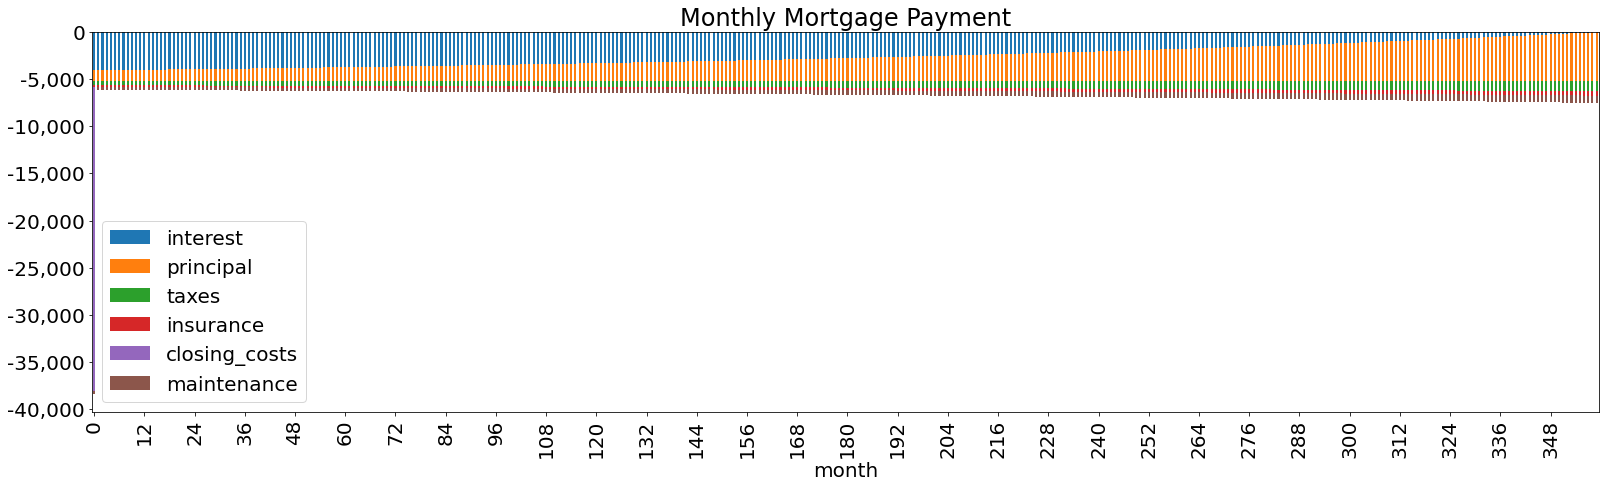

In [8]:
plot_payments(df[['month', 'interest', 'principal', 'taxes', 'insurance', 'closing_costs', 'maintenance']])

_Oof_, but do those closing costs hurt.  When you take a cumulative view over time, though, they start to get swamped by the other parts of your payment rather quickly.

/tmp/ipykernel_119497/3307871255.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])


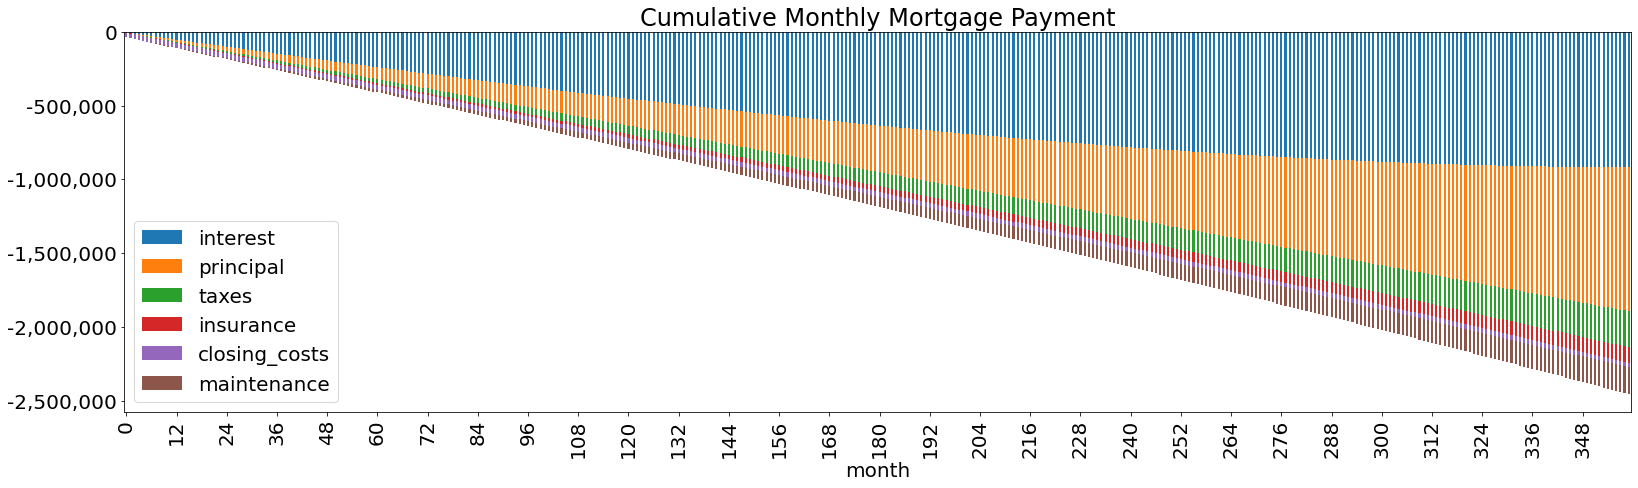

In [9]:
cumsum_df = df[['month', 'interest', 'principal', 'taxes', 'insurance', 'closing_costs', 'maintenance']].cumsum()
cumsum_df["month"] = periods
plot_payments(cumsum_df, title="Cumulative Monthly Mortgage Payment")

In [10]:
df = df.merge(cumsum_df[['principal', 'month']], on='month', suffixes=('_monthly', '_cumulative'))


### But those aren't the true costs!

## Taxes

In the US, mortgage interest is tax deductible up to a certain amount.  This means that you get to pay mortgage interest with pre-tax money instead of post-tax money, and that means **your net mortgage payment goes down the more money you make**, marriage status, and other factors.

### A very short summary of taxes for most people

Basically, you have an income, call it \\$100,000 for round numbers.  Some amount of that is paid in taxes; [at \\$100K it's about 28.5% if you live in DC.](https://smartasset.com/taxes/income-taxes#7kHeg6CWcc).  Then your take-home pay is \\$71.5K, and your taxes are \\$28.5K.  If you had to pay a \\$10K expense, your income would be reduced to \\$61.5K.

But there is a small list of expenses that is _deductible_; they lower the amount of money that is counted as your income.  If your \\$10K expense is deductible, you pay it out of your \\$100K pre-tax income, then you are only taxed on the remaining \\$90K: your take home is \\$65.4K and your taxes are \\$24.6K.  

Observe the difference there.  If your \\$10K expense is deductible, your net pay is \\$65.4K.  If it's not, your net pay is \\$61.5K.  Basically, deductions let you pay for things with pre-tax dollars, and only net lose the post-tax quantity.  If your tax rate is 50%, then you can pay for something that costs \\$100K but only lose \\$50K from your bank account.  _And the savings come from taxes you don't pay._

This means that the higher your tax rate, the bigger a discount you get on things if they are deductible. And mortgage interest is deductible, so higher earners pay less money for things like mortgage interest on net, even if the mortgages are otherwise the same.

### Revisiting Mortgage Payments



Let's recalculate the monthly mortgage payments with the haircut to mortgage interest from tax savings.

/tmp/ipykernel_119497/3307871255.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])


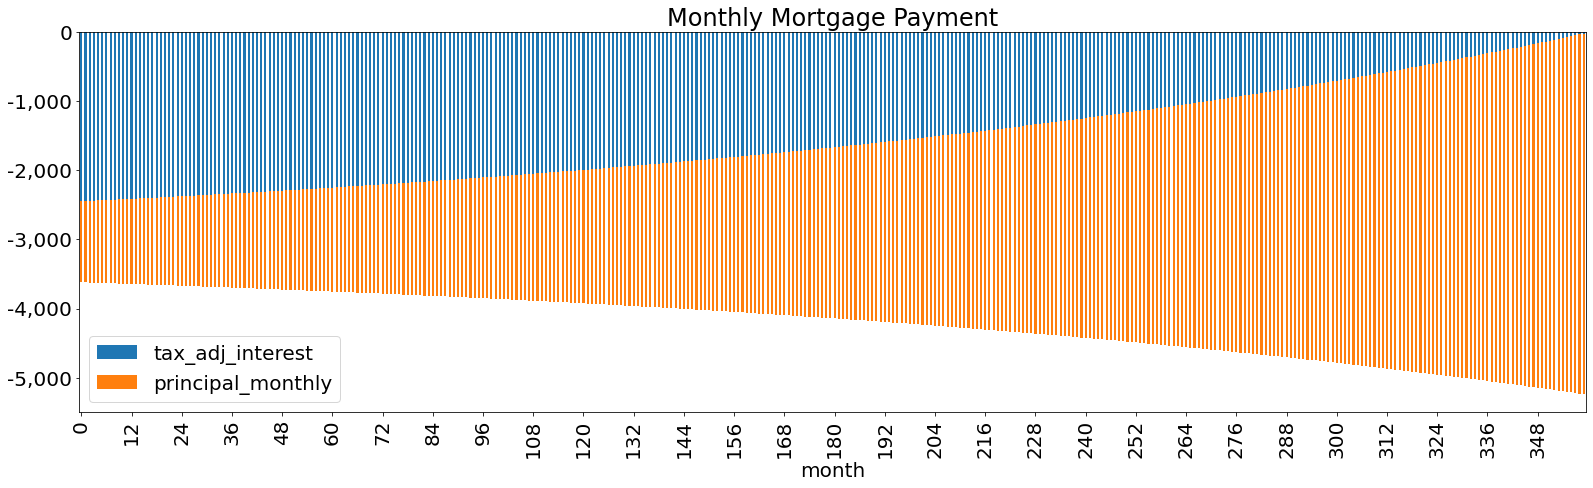

In [11]:
tax_rate = 0.4

df['tax_adj_interest'] = df['interest']*(1-tax_rate)
plot_payments(df[['tax_adj_interest', 'principal_monthly', 'month']])

Instead of the first month's payment being mostly interest, now it is mostly principal.

And, taxes and insurance are deductible (up to a cap) as well, so those get cheaper.

/tmp/ipykernel_119497/3307871255.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])


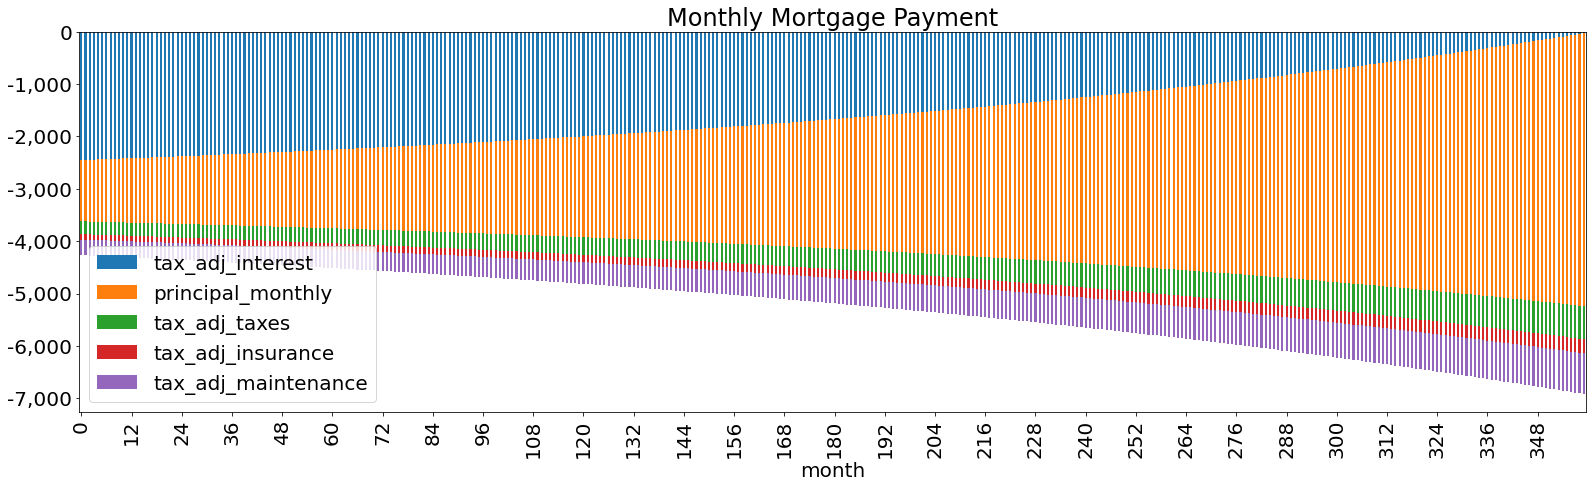

In [12]:
df["tax_adj_taxes"] = df["taxes"]*(1-tax_rate)
df["tax_adj_insurance"] = df["insurance"]*(1-tax_rate)
df["tax_adj_maintenance"] = df["maintenance"] # Maintenance on non-rental properties is not deductible
plot_payments(df[['tax_adj_interest', 'principal_monthly', 'month', "tax_adj_taxes", "tax_adj_insurance", "tax_adj_maintenance"]])

Instead of the first month's payment being \\$4230, it's now about \\$3250.  That's a giant change!

### There Is One Last Big Cost

We haven't even talked about the other big expense: closing costs on selling.  In DC, the _seller_ pays 6% of the sale price as commission to the realtors/brokers.  The closing costs we paid up front were just for financing.  This means that we pay the same 6% no matter when we sell; if we sold in month 2, we would pay the \\$27K of month 1, followed by the \\$60K of month 2!  Our housing dalliance would cost almost \\$100K total to get in and out.

Now, we can estimate the profit from selling out mortgage early.  We can calculate how much the house is worth to sell at that point, pay off the balance of the mortgage, subtract everything we have paid up until then, subtract 6% of the house value, and the balance is profit.

/tmp/ipykernel_119497/3307871255.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])


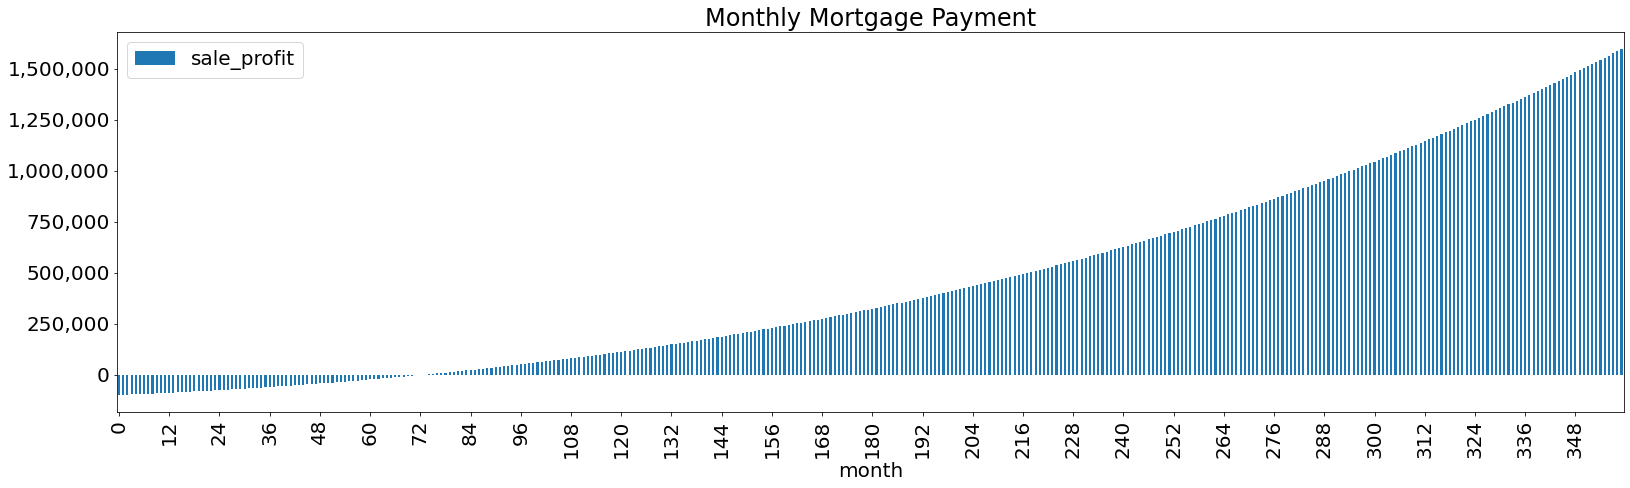

In [13]:
sale_tax = 0.06
df['remaining_loan'] = mortgage_amount + df['principal_cumulative']
df['sale_revenue'] = df['home_value'] - df['remaining_loan']
df['sale_tax'] = -df['home_value'] * sale_tax
df['tax_adj_interest_cumul'] = df['tax_adj_interest'].cumsum()
df['tax_adj_insurance_cumul'] = df['tax_adj_insurance'].cumsum()
df['tax_adj_taxes_cumul'] = df['tax_adj_taxes'].cumsum()
df['tax_adj_maintenance_cumul'] = df['tax_adj_maintenance'].cumsum()
df['closing_costs_cumul'] = df['closing_costs'].cumsum()

df["down_payment"] =  np.zeros(360)
df.at[0, 'down_payment'] = -down_payment
df['down_payment_cumul'] = df['down_payment'].cumsum()

df['net_cashflow'] = df['down_payment'] + df['closing_costs'] + df['tax_adj_interest'] + df['tax_adj_insurance'] + df['tax_adj_maintenance'] + df['tax_adj_taxes']
df['net_cashflow_cumsum'] = df['net_cashflow'].cumsum()

df['sale_profit'] = round(df['sale_revenue'] + df['sale_tax'] + df['net_cashflow_cumsum'], 2)
plot_payments(df[['sale_profit', 'month']])

Note: the profitability of buying starts out negative, and flips to positive after about 3 years.  This is probably where some of the conventional wisdom about needing to be in a place for 5 years for it to be "worth it" comes from.  (It takes longer with a lower tax rate.)

### Q3: Investments

The above analysis is good, but we need a digression into investment math.  

**Instead of buying a house, we could put our down payment in the stock market and rent.  Which is better?**

Answering this question will be very powerful, and also give us the tools to compare different arrangements on a house, like having a housemate.  

I know there is a lot of theory here, but the agenda is:
 * Explain stocks and how to compare them
 * Expand to streams of payments and how to compare those
 * Represent buying a house and renting as streams of payments and compare them

#### Stocks 101

A stock is a piece of paper that occasionally pays a dividend, but is primarily valuable for trading. Let's look at the S&P500 for simplicity. 

In [14]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2021, 11, 27)
SP500 = web.DataReader(["sp500"], "fred", start, end)

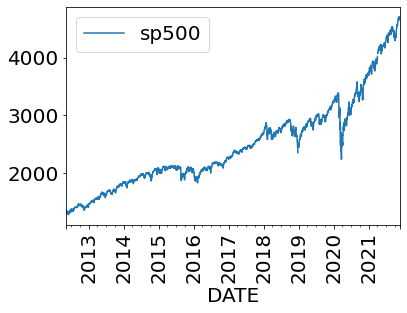

In [15]:
SP500.plot()
plt.xticks(rotation=90)
plt.show()

With stocks, you put money in at a place on the line, and take it out sometime to the right, and your profit is the difference in the two values.  

When you smooth the above chart aggressively, you can model it as an investment with a 17% interest rate.  This means if you invest \\$1000, it's worth \\$1185 at the end of year 1, \\$1404 at the end of year 2, and $1973 at the end of year 4.

In the SP500 case, the first value is \\$1277 and the last is \\$4595.

Note: These numbers are not inflation adjusted, so true returns are lower.  But even with inflation 17% returns over the long term are _insane_. 

<AxesSubplot:>

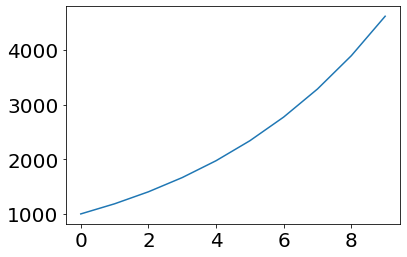

In [16]:
interest_rate = 0.17
compound_interest = np.arange(0, 10) * interest_rate
compounding_df = pd.DataFrame()
compounding_df["interest_based_return"] = np.exp(compound_interest) * 1000
compounding_df["interest_based_return"].plot()

In [17]:
compounding_df

,interest_based_return
0,1000.000000
1,1185.304851
2,1404.947591
3,1665.291195
4,1973.877732
5,2339.646852
6,2773.194764
7,3287.081207
8,3896.193302
9,4618.176822


Note: the 1000->4618 move is pretty close to the 1277 to 4595 move, so the 17% approximation seems to be close to right.

With interest-based investments, you only pay at the start and get paid at the end; there is nothing tricky going on in between.  Assuming variance is zero for a moment, interest based investments are very easy to compare: higher numbers are better.

#### Internal Rate of Return calculations

Internal rate of return calculations extend the "higher numbers are better" framework beyond "pay once now, get paid once later" into any series of payments.  For example, an IRR lets you figure out the comparable "interest rate" of paying \\$100K now to get paid \\$11K every other month for 2 years.  Note that interest based investments become a special case of IRR calculations where there are only two payments.

How exactly IRRs work mathematically is a topic for another time.  Mechanically computing them can be done with the numpy-financial package.  Let's demonstrate with two examples: 
 * Case A) paying \\$100K now to get paid \\$11K every other month for 2 years
 * Case B) paying \\$80K now to get paid \\$10K every other month for 1.5 years
 * Case C) paying \\$50K to buy stock that appreciates at 2% annually and holding for 2 years.

In [18]:
# Case A
round(
    npf.irr(
        [
            -100000,  # End of 0 Month
            0,      # End of 1 Month
            11000,  # End of 2 Month
            0,
            11000,
            0,
            11000,
            0,
            11000,
            0,
            11000,
            0,
            11000,  # End of 12 Month
            0,
            11000,
            0,
            11000,
            0,
            11000,
            0,
            11000,
            0,
            11000,
            0,
            11000,  # End of 24 Month
        ]
    ),
    5,
) * 100 * 12 # Multiply by 12 to make the monthly rate an annual one



27.012

In [19]:
# Case B
round(
    npf.irr(
        [
            -80000,  # End of 0 Month
            0,      # End of 1 Month
            10000,  # End of 2 Month
            0,
            10000,
            0,
            10000,
            0,
            10000,
            0,
            10000,
            0,
            10000,  # End of 12 Month
            0,
            10000,
            0,
            10000,
            0,
            10000,
            0,
            0,
            0,
            0,
            0,
            0,  # End of 24 Month
        ]
    ),
    5,
) * 100 * 12 # Multiply by 12 to make the monthly rate an annual one

14.448

In [20]:
# Case C
investment = 50000
interest = 0.02
round(
    npf.irr(
        [
            -investment,  # End of 0 Year
            0,            # End of 1 Year
            investment * math.exp(interest * 2),  # End of 2 Year
        ]
    ),
    5,
) * 100

2.02

Here are our IRR results:
 * Case A)'s is 27%, 
 * Case B)'s is 14.4%, 
 * Case C)'s is 2.02%.  

Not only do we know which one is better, we know by how much.  Note that the IRR of an interest-based investment is very close to the interest rate, which is convenient.

#### Buying and renting as streams of payments

It's actually kind of a pain to represent the stream of payments of "what if we sell in month 1, or 2, or 12, etc.  We need to remake the df every time, and IIR each of those individually.

In [34]:
periods = 180
irr_df = pd.DataFrame(data={
    "month": np.arange(periods),
    "buy_irr": np.zeros(periods),
    "rent_irr": np.zeros(periods),
})
pd.set_option('display.max_columns', 500)
for x in range(2, periods):
    df.at[x-2, 'sale_cashflow'] = 0
    df.at[x-1, 'sale_cashflow'] = df.at[x-1, "sale_revenue"] + df.at[x-1, "sale_tax"]
    df['net_cashflow_with_closing'] = df['net_cashflow'] + df['sale_cashflow'] + 3000 # add monthly rent
    irr = round(
        npf.irr(
            df['net_cashflow_with_closing'][:x]
        ),
        5,
    ) * 100 * 12
    irr_df.at[x, "buy_irr"] = irr
    
#     This can take a while for longer data series.  Print a checkpoint number to demonstrate progress is still happening.
    if x % 36 == 0: 
        print(x)
        

36
72
108
144


<AxesSubplot:>

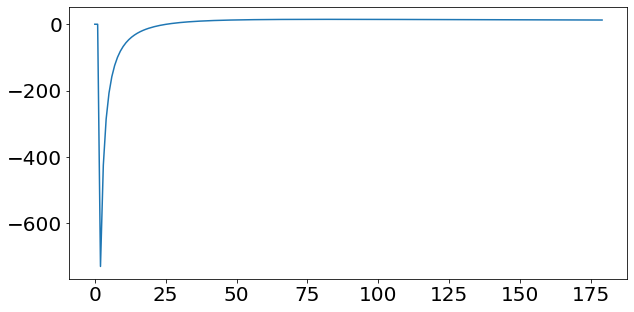

In [35]:
irr_df['buy_irr'].plot(figsize=(10,5))

It _really_ sucks to not hold your house for at least a few years.  If we clip the scale, we can zoom in on the interesting part.

(-5.0, 18.0)

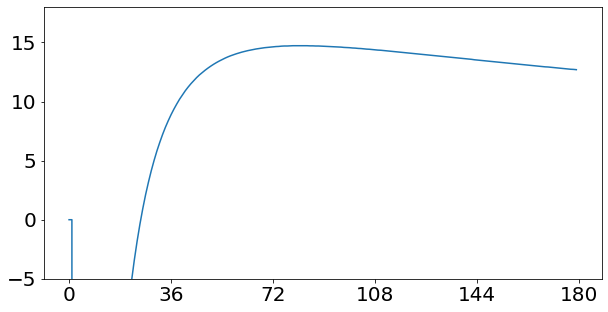

In [36]:
ax = irr_df['buy_irr'].plot(figsize=(10,5))
plt.xticks(np.arange(0, len(irr_df) + 1, 36))
ax.set_ylim((-5, 18),)

We have an IRR that starts negative, flips positive at the time buying the house stops being a losing trade, and gets up to almost 6%.

This is great!  Recall that the IRR for an interest investment is very close to the interest rate.  We know about how good holding a house would be if it were an interest investment, based on how long we held it!

### IRR of renting

In [24]:
interest_rate = 0.17
annual_rent_increase = 0.03
rent_i_pay = -1100
renting_df = pd.DataFrame(data={
    'month': np.arange(0, 360),
    'investment_value': np.exp(np.arange(0, 360)* interest_rate/12) * down_payment,
    'monthly_rent_cost': np.exp(np.arange(0, 360)* annual_rent_increase/12) * rent_i_pay,
})

# Specify that we sell at the end of the 30 year period
renting_df['investment_proceeds'] = np.zeros(360)
renting_df.at[359, 'investment_proceeds'] = renting_df.at[359, 'investment_value']
renting_df.at[0, 'investment_proceeds'] = -down_payment

renting_df['net_cashflow'] = renting_df['monthly_rent_cost'] + renting_df['investment_proceeds']

renting_df['total_rent_paid'] = renting_df['monthly_rent_cost'].cumsum()

round(
    npf.irr(
        renting_df['net_cashflow']
    ),
    5,
) * 100 * 12

14.952

Renting has a much, much bigger IRR.  A big part of that is our 17% investment increase assumption. 

<AxesSubplot:>

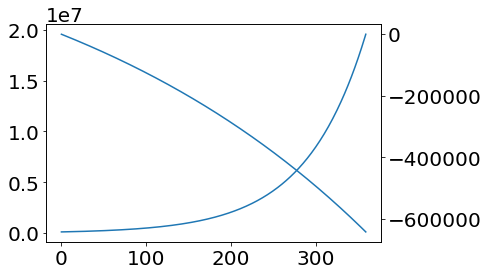

In [25]:

ax1 = renting_df['investment_value'].plot()


ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
renting_df['total_rent_paid'].plot(ax=ax2)

Paying 600K of rent over 30 years doesn't matter when our 200K grows into >\\$3M.

But the 17% return 1) has inflation in it, 2) is crazy high historically.  What investment return brings us closer to the house IRR?

In [26]:
interest_rate = 0.08
annual_rent_increase = 0.03
rent_i_pay = -1100
renting_df = pd.DataFrame(data={
    'month': np.arange(0, 360),
    'investment_value': np.exp(np.arange(0, 360)* interest_rate/12) * down_payment,
    'monthly_rent_cost': np.exp(np.arange(0, 360)* annual_rent_increase/12) * rent_i_pay,
})

# Specify that we sell at the end of the 30 year period
renting_df['investment_proceeds'] = np.zeros(360)
renting_df.at[359, 'investment_proceeds'] = renting_df.at[359, 'investment_value']
renting_df.at[0, 'investment_proceeds'] = -down_payment

renting_df['net_cashflow'] = renting_df['monthly_rent_cost'] + renting_df['investment_proceeds']


round(
    npf.irr(
        renting_df['net_cashflow']
    ),
    5,
) * 100 * 12

3.24

If we thought a stock market investment would only return about 8%, then buying a house and investing the downpayment would be about comparable over the 30 year horizon.


#### Building the picture more

Hopefully by this point I have convinced you that buying a house 
 * is not so clearly better than renting always, 
 * is actually dependent on a lot of factors, 
 * has many hidden costs.  

But, we've also explored a tool that lets us make comparisons more easily.  And because IRR calculations compare any two streams of payments, that are not just good for comparing buying a house to buying stocks; they are also good for comparing the outcomes of buying _two different houses_.

Up next: rental income, and a calculator!